# PV-IN KCNC2 Kv3.2 A new genetic cause of childhood epilepsy


## imports and config

In [1]:
%load_ext autoreload
%autoreload 2
import logging
import platform

from pathlib import Path
from functools import lru_cache
from itertools import product
from neuron import h
from neuron import gui
from tqdm import tqdm
from typing import Iterable, Union
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from src.cells.pv_nrn import get_pv, get_pv_params, set_nrn_prop, mut, set_relative_nav11bar

from src.constants import *
from src.settings import *
from src.data import get_cached_df, get_file_path, set_cache_root, get_cache_root, wide_to_long, concise_df
from src.measure import get_max_propagation, get_ap_times, calculate_failures
from src.run import get_trace
from src.utils import get_key, str_to_tuple, nearest_idx, nearest_value, nearest_idx_val, get_last_sec
from src.vis import plot_voltage_trace, set_default_style, save_fig, get_pulse_times, get_pulse_xy
from src.nrn_helpers import init_nrn, env_var, remove_cell_from_neuron

logging.basicConfig(level=logging.INFO)

for logger in ["fontTools"]:
    logging.getLogger(logger).setLevel(logging.WARNING)

if platform.system() == 'Windows':
    set_cache_root("D:\\.cache")

init_nrn(celsius=34, v_init=-80) # as in BBP optimisation

h.check_simulator() # method from PV_template.hoc that checks if parameters used during optimisation are the same as those used during simulation

set_default_style()

INFO:nrn_helpers:celsius=34.0 and v_init=-80.0


## Point neurons

In [2]:
from nrnutils import Section, Mechanism

# define ion channel parameters
leak = Mechanism("pas", e=-30, g=1e-5)
leak_mut = Mechanism("pas", e=-65, g=1e-5)
# uses ek and has param gSKv3_1bar

kv3 = Mechanism("SKv3_1")
kv3_mut = Mechanism("SKv3_1m")
props = dict(L=30, diam=15, nseg=3, cm=1)
passive_point_neuron = ppn = Section(**props, mechanisms=[leak, kv3], name="WT")
passive_point_neuron_mutant = ppn_mut = Section(
    **props, mechanisms=[leak_mut, kv3_mut], name="C165Y"
)

# change property without creating new neurons/mechanisms
def set_seg_prop(nrn: Section, prop: str, value: float):
    for seg in nrn:
        setattr(seg, prop, value)


def change_mech_props(nrn: Section, mech="SKv3_1", **prop_value_dict):
    for seg in nrn:
        for prop, value in prop_value_dict.items():
            setattr(getattr(seg, mech), prop, value)


set_seg_prop(ppn, "ek", -60)
set_seg_prop(ppn_mut, "ek", -120)

# Objects
t_vec = h.Vector()
v = h.Vector()
v_mut = h.Vector()
ik = h.Vector()
ik_mut = h.Vector()

# record
t_vec.record(h._ref_t)  # only once a section is created
v.record(ppn(0.5)._ref_v)
v_mut.record(ppn_mut(0.5)._ref_v)
ik.record(ppn(0.5)._ref_ik)
ik_mut.record(ppn_mut(0.5)._ref_ik)
vclamp = h.SEClamp(ppn(0.5))
vclamp_mut = h.SEClamp(ppn_mut(0.5))

v_init = env_var()["v_init"]
vclamp.dur1 = vclamp_mut.dur1 = 10
vclamp.dur2 = vclamp_mut.dur2 = 100
vclamp.dur3 = vclamp_mut.dur3 = 100
vclamp.amp1 = vclamp_mut.amp1 = v_init
vclamp.amp2 = vclamp_mut.amp2 = v_init  # this will be changed
vclamp.amp3 = vclamp_mut.amp3 = -40
vclamp.rs = vclamp_mut.rs = 0.01

str(ppn)


"Section(L=30.0, Ra=100.0, nseg=3, rallbranch=1.0, diam=15.0, cm=1.0, mechanisms=[Mechanism(name=pas, parameters={'e': -30, 'g': 1e-05}),Mechanism(name=SKv3_1, parameters={})], synapses=[], parent=_)"

### Helpful functions for calculating currents and time constants

In [3]:
def calc_tail_current(ik_np: np.ndarray, t_np: np.ndarray, vclamp: h.SEClamp):
    """
    Calculates tail current for a given vclamp value
    """
    tail_current = np.mean(
        ik_np[
            (t_np > (vclamp.dur2 + vclamp.dur1))
            & (t_np < (vclamp.dur2 + vclamp.dur1 + 10))
        ]
    )
    return tail_current


def calc_activation_time_constant_tau(
    ik_np: np.ndarray, t_np: np.ndarray, vclamp: h.SEClamp
):
    """
    Calculates activation time constant for a given vclamp value
    """
    rise_idx = np.where((t_np > vclamp.dur1) & (t_np < (vclamp.dur2 + vclamp.dur1)))[0]
    activation_ik = ik_np[rise_idx]

    # find idx for 1-1/e of max
    idx = nearest_idx(activation_ik, activation_ik[-1] * (1 - np.exp(-1)))
    return t_np[rise_idx[0] + idx] - t_np[rise_idx[0]]


def calc_deactivation_time_constant_tau(
    ik_np: np.ndarray, t_np: np.ndarray, vclamp: h.SEClamp
):
    """
    Calculates deactivation time constant for a given vclamp value
    """
    decay_idx = np.where(
        (t_np > (vclamp.dur2 + vclamp.dur1))
        & (t_np <= (vclamp.dur2 + vclamp.dur1 + vclamp.dur3))
    )[0]
    # find idx for 1/e of max
    tail_ik_np = ik_np[decay_idx]
    t_idx = int(0.5//h.dt)
    is_decay = (tail_ik_np[t_idx] - tail_ik_np[-1]) > 0
    if is_decay:
        idx = nearest_idx(tail_ik_np, tail_ik_np[t_idx] * np.exp(-1))
    else:
        idx = nearest_idx(tail_ik_np, tail_ik_np[t_idx] * (1 - np.exp(-1)))
    return t_np[decay_idx[0] + idx] - t_np[decay_idx[0]]

def interpolate(points: pd.DataFrame, step_size: float) -> float:
    """
    Interpolate a point in a line.
    """
    interp_points = points.reindex(index=np.arange(points.index.min(), points.index.max()+1, step_size))
    interp_points = interp_points.interpolate(method="linear", limit_direction="both")
    return interp_points


def find_v_half(points: pd.DataFrame):

    # find v 1/2 point for peak ik
    idx = nearest_idx(points["peak ik"].values, points["peak ik"].max()/2)
    v_half_peak = points.iloc[idx]["v"]
    return idx, v_half_peak


### Voltage clamp IV curve

In [4]:
def iv_fig(vclamp_values=None, ppn_props=None, ppn_mut_props=None, tstop=210):
    """
    Plots IV curve for the ppn and ppn_mut point neurons.

    **Note** that ppn_props permantly changes the properties of the ppn point neuron.

    """
    if vclamp_values is None:
        vclamp_values = np.arange(-65, 50, 5)
    ppn_props = ppn_props or {}
    ppn_mut_props = ppn_mut_props or {}

    h.tstop = max(tstop, vclamp.dur1 + vclamp.dur2 + vclamp.dur3)

    points = pd.DataFrame()

    # only initial vclamp_values will be plotted, but simulations will be run for these values
    extended_vclamp_values = np.arange(vclamp_values.min(), vclamp_values.max() + 1, 1)

    change_mech_props(ppn, **ppn_props)
    change_mech_props(ppn_mut, "SKv3_1m", **ppn_mut_props)

    sample_lines = {
        "v": [],
        "ik": [],
        "ik_mut": [],
    }

    for amp in tqdm(extended_vclamp_values):
        vclamp.amp2 = vclamp_mut.amp2 = amp

        h.finitialize(env_var()["v_init"])
        h.run()

        t_np = t_vec.as_numpy()
        v_np = v.as_numpy()
        ik_np = ik.as_numpy()
        v_mut_np = v_mut.as_numpy()
        ik_mut_np = ik_mut.as_numpy()

        if amp in vclamp_values:
            sample_lines["v"].append(np.array(v_np))  # copy data
            sample_lines["ik"].append(np.array(ik_np))
            sample_lines["ik_mut"].append(np.array(ik_mut_np))

        points = pd.concat(
            [
                points,
                pd.DataFrame(
                    {
                        "v": [vclamp.amp2, vclamp_mut.amp2],
                        "peak ik": [max(ik_np), max(ik_mut_np)],
                        "tail ik": [
                            calc_tail_current(ik_np, t_np, vclamp),
                            calc_tail_current(ik_mut_np, t_np, vclamp_mut),
                        ],
                        "tau activation": [
                            calc_activation_time_constant_tau(ik_np, t_np, vclamp),
                            calc_activation_time_constant_tau(
                                ik_mut_np, t_np, vclamp_mut
                            ),
                        ],
                        "tau deactivation": [
                            calc_deactivation_time_constant_tau(ik_np, t_np, vclamp),
                            calc_deactivation_time_constant_tau(
                                ik_mut_np, t_np, vclamp_mut
                            ),
                        ],
                        "Kv3.2": [ppn.name(), ppn_mut.name()],
                    },
                    # index=[0, 1], # only needed if single row
                ),
            ],
            ignore_index=True,
        )

    # clean up dataframe
    # convert ik in mA/cm2 to pA/pF using membrane capacitance (uF/cm2)
    points["peak ik"] = points["peak ik"] * 1e3 / ppn.cm
    points["tail ik"] = points["tail ik"] * 1e3 / ppn.cm

    return points, sample_lines



100%|██████████| 111/111 [00:01<00:00, 90.28it/s]


(0.0, 54.198749999971156)

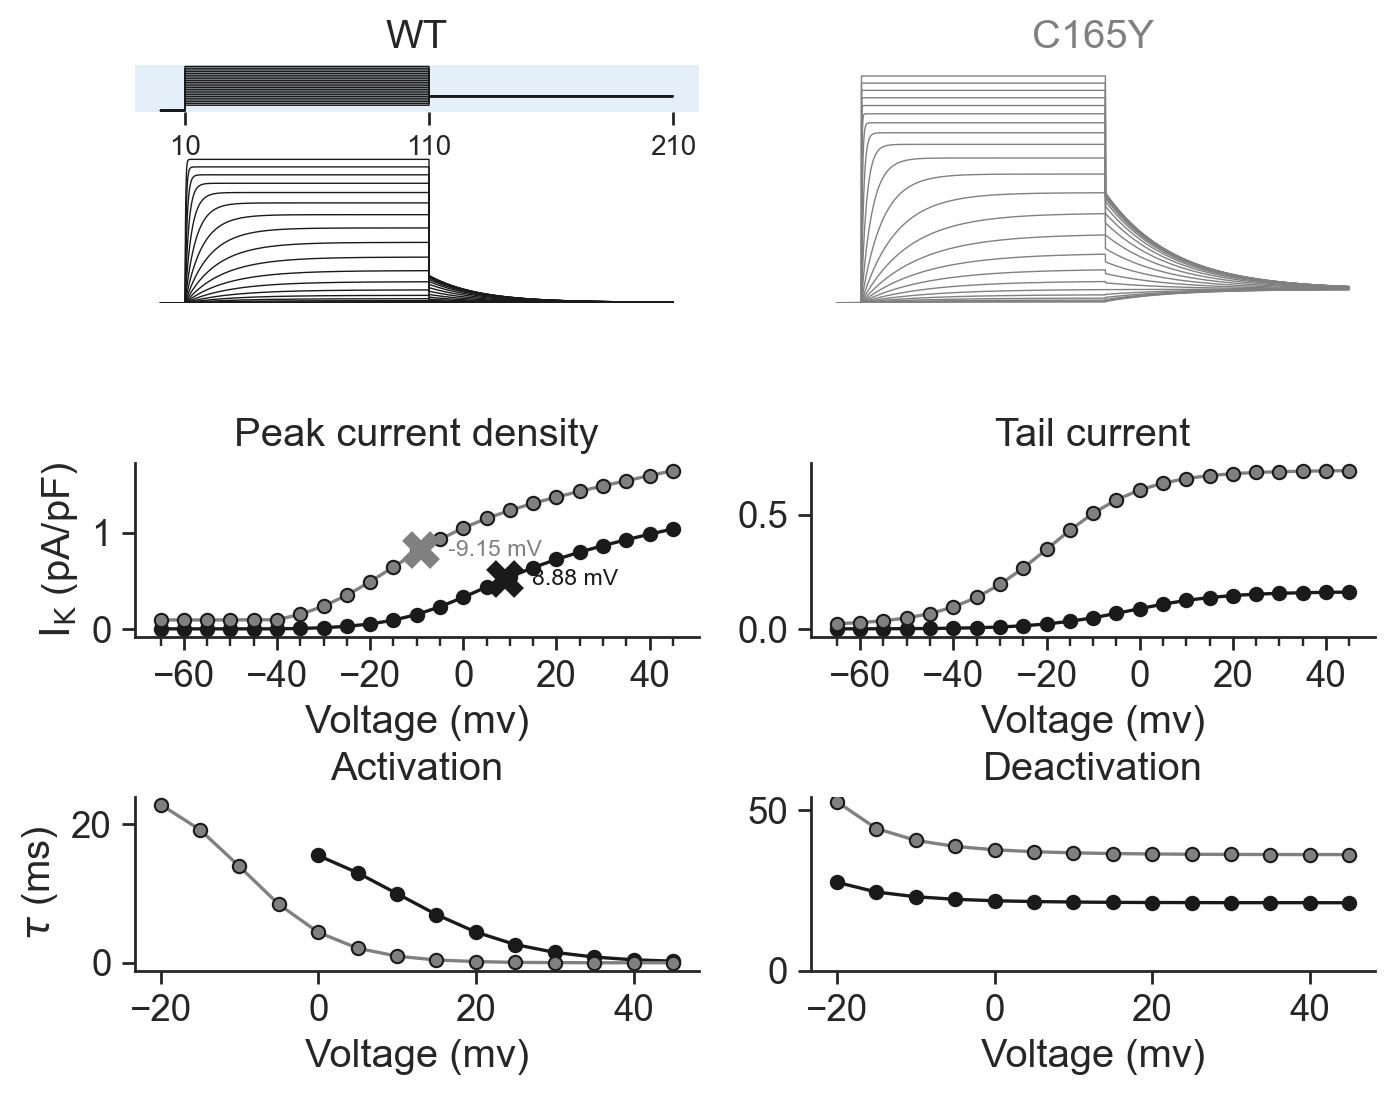

In [5]:
vclamp_values = np.arange(-65, 50, 5)
points, sample_lines = iv_fig(vclamp_values)

t_np = t_vec.as_numpy().copy()

##########
# Figure
##########
sns.set_context("paper", font_scale=1.5)

fig, axes = plt.subplot_mosaic(
    [
        ["ik", "ik_mut"],
        ["ik", "ik_mut"],
        ["i-v peak", "i-v tail"],
        ["tau activation", "tau deactivation"],
    ],
    gridspec_kw={"height_ratios": [0.4, 0.5, 2, 2], "hspace": 1.5},
    dpi=200,
    figsize=(8, 6),
)
# create inset axis
axes["v"] = axes["ik"].inset_axes([0.0, 0.8, 1.0, 0.2])

# plot sample lines
for key in sample_lines.keys():
    c = "gray" if "mut" in key else "k"
    for i, line in enumerate(sample_lines[key]):
        axes[key].plot(t_np, line, lw=0.5, c=c)

# take only vclamp values
plot_points = points[points["v"].isin(vclamp_values)]

VOLTAGE_MV = "Voltage (mv)"

sns.lineplot(
    data=plot_points,
    x="v",
    y="peak ik",
    ax=axes["i-v peak"],
    hue="Kv3.2",
    palette=["k", "gray"],
    marker="o",
    markeredgecolor="k",
    legend=False,
)
sns.lineplot(
    data=plot_points,
    x="v",
    y="tail ik",
    ax=axes["i-v tail"],
    hue="Kv3.2",
    palette=["k", "gray"],
    marker="o",
    markeredgecolor="k",
    legend=False,
)

# plot voltage at half peak
for key, c in zip(["WT", "C165Y"], ["k", "gray"]):
    df_kv = points[points["Kv3.2"] == key].reset_index()
    interp_points = interpolate(df_kv, 0.01)
    df_kv["Relative conductance"] = df_kv["peak ik"] / df_kv["peak ik"].max()
    interp_points["Relative conductance"] = (
        interp_points["peak ik"] / interp_points["peak ik"].max()
    )

    v_half_idx, v_half = find_v_half(interp_points)
    # print(f"{v_half=}")
    xy = (v_half, interp_points.iloc[v_half_idx]["peak ik"])
    axes["i-v peak"].annotate(
        f"{xy[0]:.2f} mV",
        xy=xy,
        xytext=(10, 0),
        textcoords="offset points",
        color=c,
        # arrowprops=dict(arrowstyle="->", color="k"),
        va="center",
        fontsize="xx-small",
    )

    axes["i-v peak"].plot(
        *xy, "x", color=c, markersize=10, markeredgewidth=5, zorder=100
    )

axes["v"].set_ylim(env_var()["v_init"] - 5, max(vclamp_values) + 5)
# set ylims the same for ik and ikmut
ymax = max(axes["ik"].get_ylim()[1], axes["ik_mut"].get_ylim()[1])
for ax in [axes["ik"], axes["ik_mut"]]:
    ax.set_ylim(0, ymax)

axes["ik"].set_title(ppn.name())
axes["ik_mut"].set_title(ppn_mut.name(), color="gray")

axes["i-v peak"].set_title("Peak current density")
axes["i-v tail"].set_title("Tail current")

for ax in [axes["v"], axes["ik"], axes["ik_mut"]]:
    sns.despine(ax=ax, left=True, bottom=True)
    ax.set(yticks=[], xticks=[])

xticks = [
    vclamp.dur1,
    vclamp.dur1 + vclamp.dur2,
    vclamp.dur1 + vclamp.dur2 + vclamp.dur3,
]
axes["v"].set_xticks(xticks)
axes["v"].set_xticklabels(np.array(xticks, dtype=int), fontsize="x-small")

# sns.despine(ax=axes["v"], top=False, right=False)
pal = sns.color_palette("Blues", n_colors=10)
axes["v"].set_facecolor(pal[0])

for ax in [axes["i-v peak"], axes["i-v tail"]]:
    ax.set_xlabel(VOLTAGE_MV)
    if ax == axes["i-v peak"]:
        ax.set_ylabel("$\\rm{I_{K}}$ (pA/pF)")
    else:
        ax.set_ylabel("")
    ax.set_xticks(plot_points["v"], minor=True)
    ax.set_xticks(
        np.arange(vclamp_values.min() + 5, vclamp_values.max() + 5, 20), minor=False
    )

for i, key in enumerate(["tau activation", "tau deactivation"]):
    min_v = -20 if "deactivation" in key else 0
    sns.lineplot(
        data=plot_points[
            (
                ((plot_points["v"] >= min_v) & (plot_points["Kv3.2"] == "WT"))
                | ((plot_points["v"] >= -20) & (plot_points["Kv3.2"] == "C165Y"))
            )
        ],
        x="v",
        y=key,
        ax=axes[key],
        hue="Kv3.2",
        hue_order=["WT", "C165Y"],
        palette=["k", "gray"],
        marker="o",
        markeredgecolor="k",
        legend=False,
    )
    axes[key].set_title(key.replace("tau ", "").capitalize())
    axes[key].set_xlabel(VOLTAGE_MV)
    if key == "tau activation":
        axes[key].set_ylabel(f"$\\tau$ (ms)")
    else:
        axes[key].set_ylabel("")

# axes["tau activation"].set_ylim(0, 40)
axes["tau deactivation"].set_ylim(0)


## PV Interneuron

In [6]:
### create method for running multiple simulations
def run_sims(pv, stims, fractions, dur, load=False, arrow=False, shape_plot=True, pv_props=None, pbar_prefix=""):

    # create pv if object not passed
    # this is useful if we want to dispose of the object after the function call
    _created_pv = False
    if isinstance(pv, str):
        pv = get_pv(pv)
        _created_pv = True
    
    if pv_props is None:
        pv_props = {}
    
    # optionally set properties of pv neuron
    for key, val in pv_props.items():
        set_nrn_prop(pv, key, val, ignore_error=True)

    if pbar_prefix:
        pbar_prefix += "|>"

    # note that we 'tuple' the product generator to convert it to an iterable of known length for the progressbar
    pbar = tqdm(tuple(product(stims, fractions)), leave=pbar_prefix=="")
    
    results = {}
    
    for stim, frac in pbar:
        amp, freq = stim
        key_name = get_key(pv, frac, stim, dur)
        pbar.set_description(f"{pbar_prefix}{key_name}")

        path = get_file_path(key_name)
        long_format_path = get_file_path(key_name, ext="arrow")

        x_df = None
        if not path.exists():
            pbar.set_description(f"{pbar_prefix}{key_name} running")
            
            pv.biophys()
            mut(pv, frac)

            # run sim and save results
            AP, x_df = get_cached_df(key_name, pv, amp, dur, stim_freq=freq, shape_plot=shape_plot)

        if arrow and not long_format_path.exists():
            """Save in .feather format, to be loaded using vaex and arrow"""
            if x_df is None:
                # load results
                pbar.set_description(f"{key_name} loading")
                AP, x_df = get_cached_df(key_name)
            # format data
            long_df = wide_to_long(x_df)
            # add metadata as columns with uniform data along the rows
            long_df[KVMUT_FRAC_LABEL] = frac
            long_df[CURRENT_LABEL] = amp
            long_df["Stim. duration"] = dur
            long_df[STIM_FREQ_LABEL] = freq
            long_df["key"] = key_name
            
            for key, val in AP.items():
                if isinstance(val, list):
                    ap_val = " ".join([str(v.n) for v in val])
                else:
                    ap_val = val.n
                long_df[f"AP_{key}"] = ap_val

            for key, val in pv_props.items():
                long_df[key] = val

            # save
            pbar.set_description(f"{key_name} saving")
            long_df.to_feather(long_format_path)
        
        if load:
            if x_df is None:
                # load results
                pbar.set_description(f"{key_name} loading")
                AP, x_df = get_cached_df(key_name)
            df = wide_to_long(x_df) if x_df is not None else None
                
            # store in dict
            results[key_name] = {
                                "df": df,
                                KVMUT_FRAC_LABEL: frac,
                                CURRENT_LABEL: amp,
                                "Stim. duration": dur,
                                STIM_FREQ_LABEL: freq,
                                "APCount": AP,
                                **pv_props,
                               }

        pbar.set_description(f"{pbar_prefix}{key_name} done")

    if _created_pv:
        remove_cell_from_neuron(pv)

    return results
    

### Adjust Kv3.2 params

In [7]:
stims = [(amp, 0) for amp in np.round(np.arange(0., 4.1, 0.1), 2)]

# either change params of the original Kv3.2 channel ("down") or the mutated Kv3.2 channel ("up")
mut_directions = {"up": [0.25], "down": [0]}

# params (values are default -> mutant)
params = dict(
    tau_gain=np.round(np.linspace(8, 6, 10), 2),
    iv_shift=np.round(np.linspace(-2.11, -20.0, 10), 2),
    iv_gain=np.round(np.linspace(-9.7, -10.2, 10), 2),
    tau_scale=np.round(np.linspace(20.0, 28, 10), 2),
    tau_shift=np.round(np.linspace(10.0, -10, 10), 2),
    # TODO: ek as a relative param per section
)

param_df = pd.DataFrame()
for mut_up_down, fracs in mut_directions.items():
    for param_key, param_space in params.items():
        actual_param = f"{param_key}_SKv3_1"
        if mut_up_down == "up":
            actual_param += "m"
            
        for param_val in param_space:
            pv_key = f"{actual_param}={param_val}"
            param_result = run_sims(
                pv_key,
                stims,
                fracs,
                dur=500,
                load=True,
                arrow=False,
                shape_plot=False, # quicker running/saving/loading but no voltage traces
                pv_props={actual_param: param_val}, # change params
                pbar_prefix=f"{mut_up_down}|>{param_key}",
            )

            for key, val in param_result.items():
                nrn_name = key[: key.find("_")]
                frac = val[KVMUT_FRAC_LABEL]
                current = val[CURRENT_LABEL]
                ap_soma = val["APCount"]["soma"].n
                ap_ais = val["APCount"]["init"].n
                ap_axon = val["APCount"]["comm"].n

                param_df = pd.concat(
                    [
                        param_df,
                        pd.DataFrame(
                            {
                                "param": actual_param,
                                "value": param_val,
                                param_key: param_val,
                                "mutation direction": mut_up_down,
                                KVMUT_FRAC_LABEL: frac,
                                CURRENT_LABEL: current,
                                "Neuron": nrn_name,
                                "loc": ["soma", "AIS", "axon"],
                                "Spikes": [ap_soma, ap_ais, ap_axon],
                            },
                        ),
                    ],
                    ignore_index=True,
                )
param_df


,param,value,tau_gain,mutation direction,Kv3.2 mutant fraction,Current (nA),Neuron,loc,Spikes,iv_shift,iv_gain,tau_scale,tau_shift
0,tau_gain_SKv3_1m,8.0,8.0,up,0.25,0.0,C165Y - 25%,soma,0.0,NaN,NaN,NaN,NaN
1,tau_gain_SKv3_1m,8.0,8.0,up,0.25,0.0,C165Y - 25%,AIS,0.0,NaN,NaN,NaN,NaN
2,tau_gain_SKv3_1m,8.0,8.0,up,0.25,0.0,C165Y - 25%,axon,0.0,NaN,NaN,NaN,NaN
3,tau_gain_SKv3_1m,8.0,8.0,up,0.25,0.1,C165Y - 25%,soma,0.0,NaN,NaN,NaN,NaN
4,tau_gain_SKv3_1m,8.0,8.0,up,0.25,0.1,C165Y - 25%,AIS,0.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
12295,tau_shift_SKv3_1,-10.0,NaN,down,0.00,3.9,WT,AIS,34.0,NaN,NaN,NaN,-10.0
12296,tau_shift_SKv3_1,-10.0,NaN,down,0.00,3.9,WT,axon,13.0,NaN,NaN,NaN,-10.0
12297,tau_shift_SKv3_1,-10.0,NaN,down,0.00,4.0,WT,soma,8.0,NaN,NaN,NaN,-10.0
12298,tau_shift_SKv3_1,-10.0,NaN,down,0.00,4.0,WT,AIS,5.0,NaN,NaN,NaN,-10.0


In [8]:
param_df[FIRING_RATE_LABEL] = param_df["Spikes"]/0.5

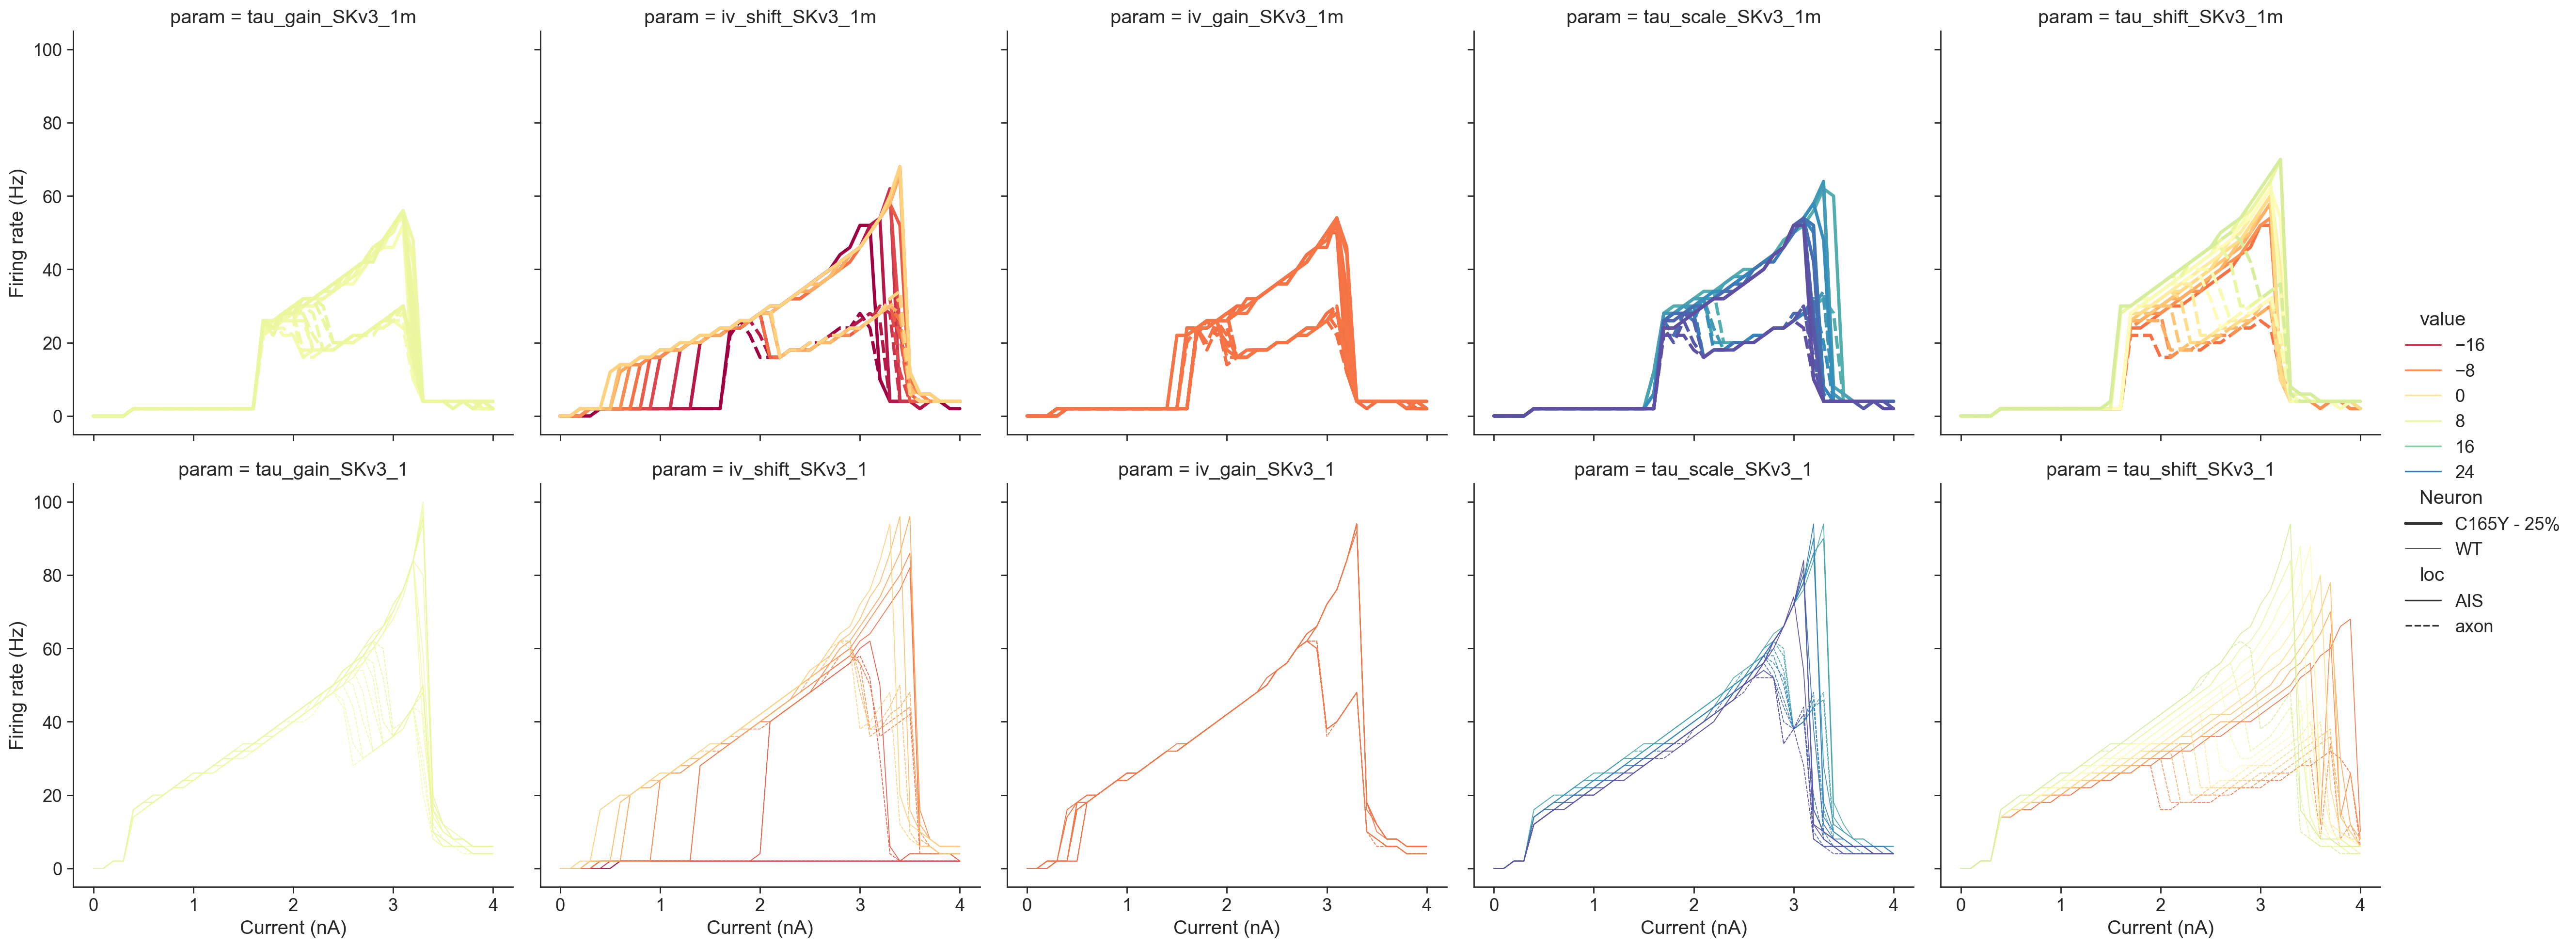

In [9]:
sns.relplot(
    data=param_df,
    col="param",
    col_wrap=5,
    # row="Neuron",
    hue="value",
    palette="Spectral",
    x=CURRENT_LABEL,
    y=FIRING_RATE_LABEL,
    size="Neuron",
    style="loc",
    style_order=["AIS", "axon"],
    kind="line",
    legend="brief",
    # facet_kws=dict(sharex=False),
)

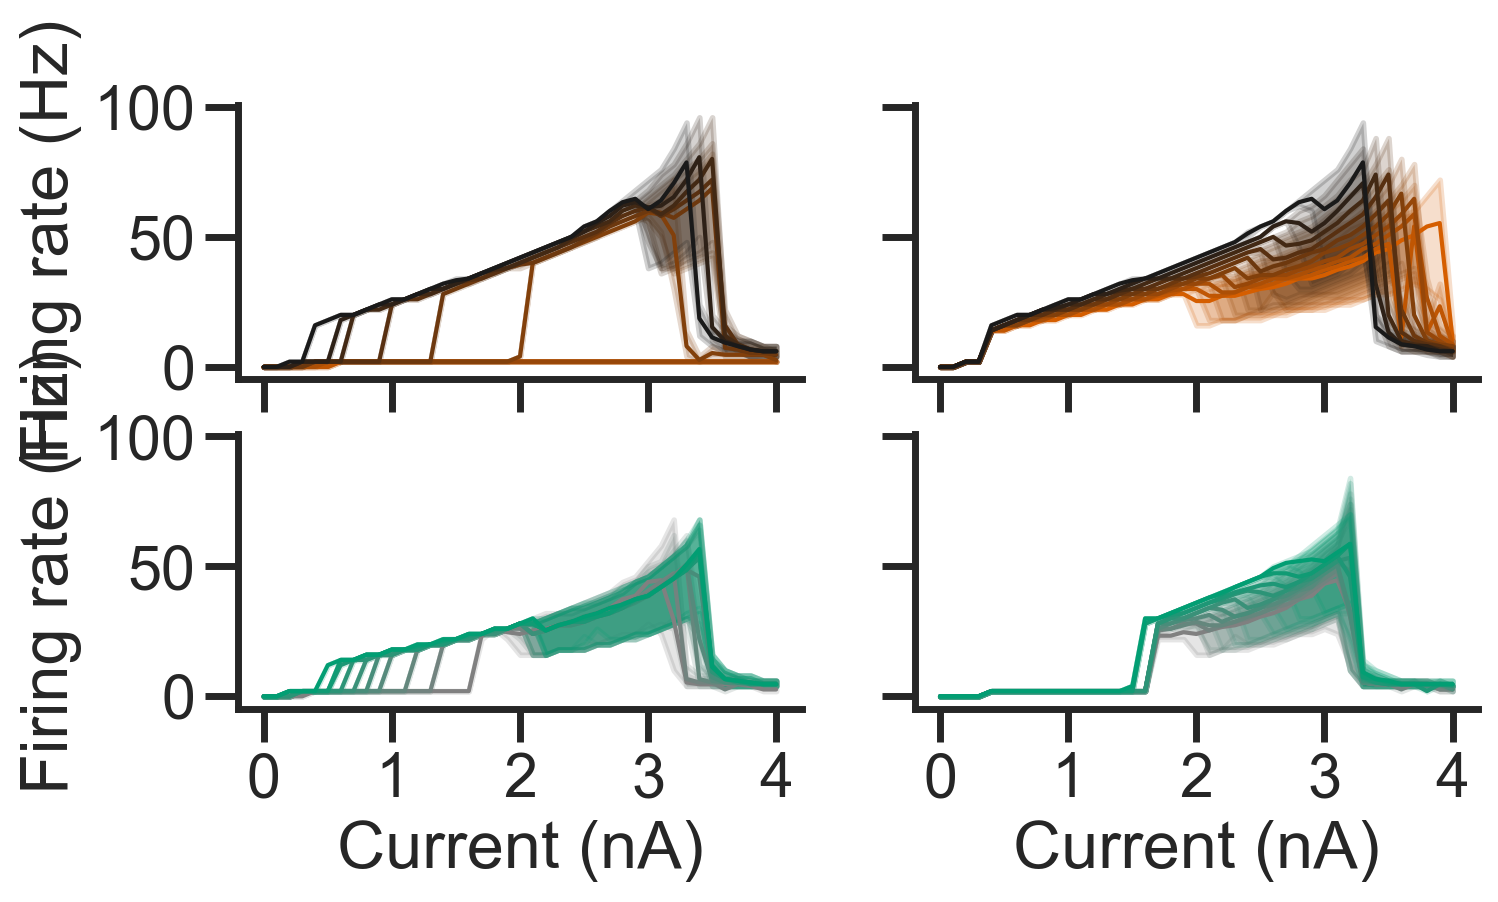

In [10]:
with sns.plotting_context("poster"):
    fig, axes = plt.subplot_mosaic(
        [
            ["iv_shift_SKv3_1", "tau_shift_SKv3_1"],  # how normal channels can be impacted
            [
                "iv_shift_SKv3_1m",
                "tau_shift_SKv3_1m",
            ],  # how pathological channels can be repaired
        ],
        sharey=True,
        sharex=True,
        figsize=(8, 4),
    )

    down_pal = sns.blend_palette(["r", "k"], n_colors=10)
    up_pal =sns.blend_palette(["grey", "g"], n_colors=10)

    base_kwargs = dict(
        x=CURRENT_LABEL,
        y=FIRING_RATE_LABEL,
        hue="value",
        # style="loc",
        # style_order=["AIS"],
        size="Neuron",
    )
    # first column

    for i, (key, ax) in enumerate(axes.items()):
        pal = up_pal if "m" in key else down_pal
            
        sns.lineplot(
            data=param_df[param_df["param"] == key],
            ax=ax,
            palette=pal,
            **base_kwargs,
            # legend=(i == 0),
            legend=False,
        )


### F-I curve

In [11]:
stims = [(amp, 0) for amp in np.round(np.arange(0.1, 4.1, 0.1), 2)]

fractions = np.round(np.arange(0, 1.01, 0.25), 2)

amp_result = run_sims("default", stims, fractions, dur=500, load=True, arrow=True)
amp_result

C165Y - 100%_default(1000.0, 30.0, 1.0, 60.0)_(4.0, 0)_500 done: 100%|██████████| 200/200 [01:58<00:00,  1.68it/s]   


{'WT_default(1000.0, 30.0, 1.0, 60.0)_(0.1, 0)_500': {'df':          Time (ms)   Section  Distance from soma (μm)  Membrane potential (mV)
  0              0.0   soma[0]                      0.0                    -80.0
  1          0.00012   soma[0]                      0.0               -80.000011
  2          0.00046   soma[0]                      0.0                -80.00004
  3          0.00134   soma[0]                      0.0               -80.000097
  4         0.003613   soma[0]                      0.0               -80.000179
  ...            ...       ...                      ...                      ...
  220820   488.24539  node[32]              1094.757928               -68.239703
  220821  501.530098  node[32]              1094.757928               -68.237326
  220822  514.814807  node[32]              1094.757928                -68.23988
  220823       520.0  node[32]              1094.757928               -68.240633
  220824       520.0  node[32]              1094.75

In [12]:

ap_df = pd.DataFrame()

for key, val in amp_result.items():
    nrn_name = key[: key.find("_")]
    frac = val[KVMUT_FRAC_LABEL]
    current = val[CURRENT_LABEL]
    ap_soma = val["APCount"]["soma"].n
    ap_ais = val["APCount"]["init"].n
    ap_axon = val["APCount"]["comm"].n

    ap_df = pd.concat(
        [
            ap_df,
            pd.DataFrame(
                {
                    KVMUT_FRAC_LABEL: frac,
                    CURRENT_LABEL: current,
                    "Neuron": nrn_name,
                    "loc": ["soma", "AIS", "axon"],
                    "Spikes": [ap_soma, ap_ais, ap_axon],
                },
            ),
        ],
        ignore_index=True,
    )
ap_df[FIRING_RATE_LABEL] = ap_df["Spikes"]/0.5
ap_df

,Kv3.2 mutant fraction,Current (nA),Neuron,loc,Spikes,Firing rate (Hz)
0,0.00,0.1,WT,soma,0.0,0.0
1,0.00,0.1,WT,AIS,0.0,0.0
2,0.00,0.1,WT,axon,0.0,0.0
3,0.25,0.1,C165Y - 25%,soma,0.0,0.0
4,0.25,0.1,C165Y - 25%,AIS,0.0,0.0
...,...,...,...,...,...,...
595,0.75,4.0,C165Y - 75%,AIS,1.0,2.0
596,0.75,4.0,C165Y - 75%,axon,1.0,2.0
597,1.00,4.0,C165Y - 100%,soma,1.0,2.0
598,1.00,4.0,C165Y - 100%,AIS,1.0,2.0


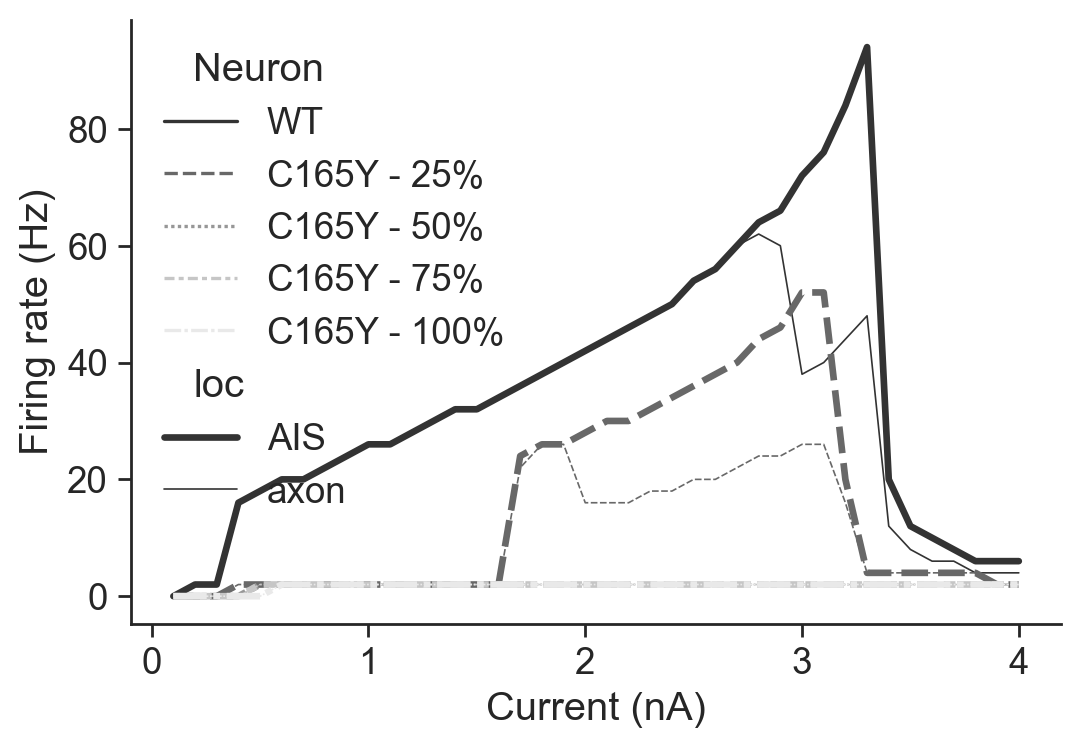

In [13]:
if ap_df.size > 0:
    sns.lineplot(
        data=ap_df,
        x=CURRENT_LABEL,
        y=FIRING_RATE_LABEL,
        hue="Neuron",
        style="Neuron",
        # markers=["o", "s", "D"],
        palette="Greys_r",
        size="loc",
        size_order=["AIS", "axon"],
        
    )


### Example trace

In [14]:
amp = 2  # nA
dur = 1000  # ms

pv_wt = get_pv("WT")

pv_mut_1 = get_pv("C165Y - 25%")
mut(pv_mut_1, 0.25)

pv_mut_half = get_pv("C165Y - 50%")
mut(pv_mut_half, 0.5)

# create datafrome for voltage at nodes
v_df = pd.DataFrame()

for nrn in [
    pv_wt,
    pv_mut_1,
    pv_mut_half,
    # pv_mut_3_4, pv_mut_half, pv_mut_quart
]:
    # set_nrn_prop(nrn, "ek", -85, ignore_error=True)
    AP, x_df = get_cached_df(nrn.name, nrn, amp, dur, shape_plot=True)
    soma = x_df.iloc[:, 0]
    tip = x_df.iloc[:, -1]

    ais_columns = sorted(set([(a,x) for a, x in x_df.columns if 'axon' in a]))
    ais_v = x_df[ais_columns[-1]]

    nrn_name = nrn.name[: nrn.name.find("(")]

    v_df = pd.concat(
        [
            v_df,
            pd.DataFrame(
                {
                    VOLTAGE_LABEL: tip.values,
                    TIME_LABEL: tip.index,
                    "Neuron": nrn_name,
                    "loc": "axon",
                },
            ),
            pd.DataFrame(
                {
                    VOLTAGE_LABEL: soma.values,
                    TIME_LABEL: soma.index,
                    "Neuron": nrn_name,
                    "loc": "soma",
                },
            ),
            pd.DataFrame(
                {
                    VOLTAGE_LABEL: ais_v.values,
                    TIME_LABEL: ais_v.index,
                    "Neuron": nrn_name,
                    "loc": "AIS",
                },
            ),
        ],
        ignore_index=True,
    )

v_df


,Membrane potential (mV),Time (ms),Neuron,loc
0,-80.000000,0.000000,WT,axon
1,-80.000004,0.000108,WT,axon
2,-79.999828,0.000404,WT,axon
3,-79.999128,0.001141,WT,axon
4,-79.997096,0.002939,WT,axon
...,...,...,...,...
93016,-59.338009,1009.315617,C165Y - 50%,AIS
93017,-59.339768,1012.896577,C165Y - 50%,AIS
93018,-59.341467,1016.477537,C165Y - 50%,AIS
93019,-59.342192,1020.000000,C165Y - 50%,AIS


[Text(0.5, 0, ''), Text(0, 0.5, ''), [], []]

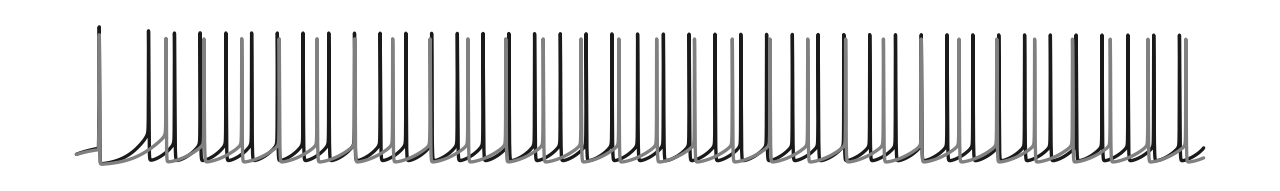

In [15]:
fig, ax = plt.subplots(figsize=(8,1))
sns.lineplot(
    data=v_df,
    x=TIME_LABEL,
    y=VOLTAGE_LABEL,
    hue="Neuron",
    hue_order=["WT", "C165Y - 25%"],
    palette=['k', 'grey'],
    style="loc",
    style_order=["AIS"],
    ax=ax,
    # alpha=0.5,
    legend=False,
)
# remove borders, labels, and ticks
sns.despine(ax=ax, left=True, bottom=True)
ax.set(xlabel="", ylabel="", xticks=[], yticks=[])

# Main figure

In [16]:
sns.set_theme(context="paper",  # poster or paper
                  style="ticks",
                  palette="colorblind",
                  rc={
                      "pdf.fonttype": 42,  # embed font in output
                      "svg.fonttype": "none",  # embed font in output
                      "figure.facecolor": "white",
                      "figure.dpi": 200,
                      "legend.frameon": False,
                      "axes.spines.left": True,
                      "axes.spines.bottom": True,
                      "axes.spines.right": False,
                      "axes.spines.top": False,
                      "savefig.bbox": "tight",
                  }
                  )

INFO:vis:saving fig_model
INFO:vis:                 .svg
INFO:vis:saved


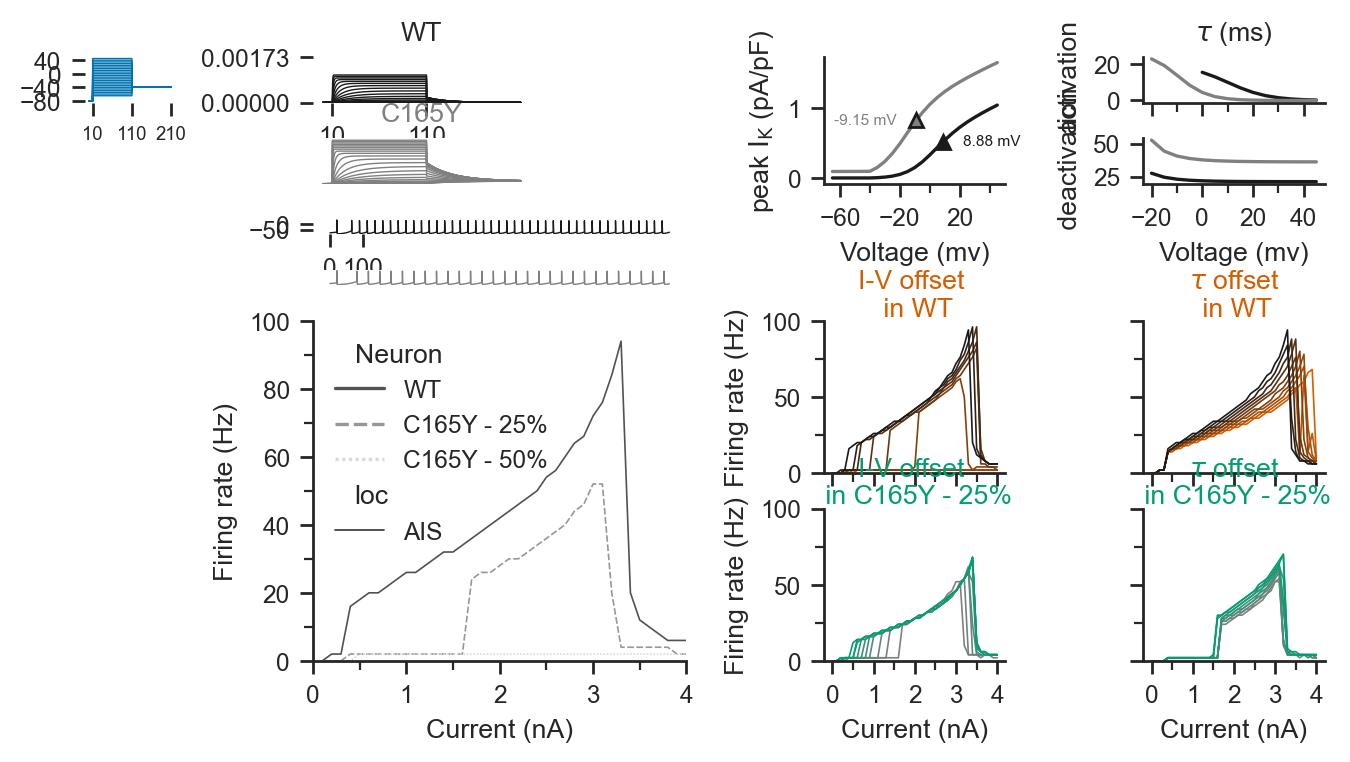

In [19]:
##########
# Figure
##########
sns.set_context("paper", font_scale=1.0)

fig, axes = plt.subplot_mosaic(
    [
        [
            "v",
            "ik",
            ".",
            "i-v peak",
            "tau activation",
        ],
        [
            ".",
            "ik_mut",
            ".",
            "i-v peak",
            "tau deactivation",
        ],
        [".", "pv_trace", "pv_trace", ".", "."],
        [".", "pv_trace_mut", "pv_trace_mut", ".", "."],
        [".", "pv_frac", "pv_frac", "iv_shift_SKv3_1", "tau_shift_SKv3_1"],
        [".", "pv_frac", "pv_frac", "iv_shift_SKv3_1m", "tau_shift_SKv3_1m"],
    ],
    gridspec_kw={
        "height_ratios": [0.3, 0.3, 0.1, 0.1, 1, 1],
        "width_ratios": [0.5, 1.2, 0.1, 1, 1],
        "hspace": 0.5,
        "wspace": 1,
    },
    dpi=200,
    figsize=(8, 4),
)
# create inset axis
# axes["v"] = axes["ik"].inset_axes([-0.5, 0.9, 1.0, 0.2])
axes_key_names = {
    "iv_shift_SKv3_1": "I-V offset",
    "tau_shift_SKv3_1": "$\\tau$ offset",
    "iv_shift_SKv3_1m": "I-V offset",
    "tau_shift_SKv3_1m": "$\\tau$ offset",
}
axes_params = {key: ax for key, ax in axes.items() if key in axes_key_names}

###############################################################################
# Point neuron data
###############################################################################

# plot sample lines
for key in sample_lines.keys():
    if key=='v':
        c = 'b'
    else:
        c = "gray" if "mut" in key else "k"
    for i, line in enumerate(sample_lines[key]):
        axes[key].plot(t_np, line, lw=0.5, c=c)

# take only vclamp values
plot_points = points[points["v"].isin(vclamp_values)]

VOLTAGE_MV = "Voltage (mv)"

sns.lineplot(
    data=plot_points,
    x="v",
    y="peak ik",
    ax=axes["i-v peak"],
    hue="Kv3.2",
    palette=["k", "gray"],
    # marker="o",
    # markeredgecolor="k",
    legend=False,
)

# plot voltage at half peak
for key, c in zip(["WT", "C165Y"], ["k", "gray"]):
    df_kv = points[points["Kv3.2"] == key].reset_index()
    interp_points = interpolate(df_kv, 0.01)
    df_kv["Relative conductance"] = df_kv["peak ik"] / df_kv["peak ik"].max()
    interp_points["Relative conductance"] = (
        interp_points["peak ik"] / interp_points["peak ik"].max()
    )

    v_half_idx, v_half = find_v_half(interp_points)
    # print(f"{v_half=}")
    xy = (v_half, interp_points.iloc[v_half_idx]["peak ik"])

    x_off = 7 if key == "WT" else -7
    axes["i-v peak"].annotate(
        f"{xy[0]:.2f} mV",
        xy=xy,
        xytext=(x_off, 0),
        textcoords="offset points",
        color=c,
        # arrowprops=dict(arrowstyle="->", color="k"),
        va="center",
        ha="left" if key == "WT" else "right",
        fontsize="xx-small",
    )

    axes["i-v peak"].plot(
        *xy, "^", color=c, mec='k', zorder=100
    )

axes["v"].set_ylim(env_var()["v_init"] - 5, max(vclamp_values) + 5)
# set ylims the same for ik and ikmut
ymax = max(axes["ik"].get_ylim()[1], axes["ik_mut"].get_ylim()[1])
for ax in [axes["ik"], axes["ik_mut"]]:
    ax.set_ylim(0, ymax)

axes["ik"].set_title(ppn.name())
axes["ik_mut"].set_title(ppn_mut.name(), color="gray")

# axes["i-v peak"].set_title("Peak current density")
# axes["i-v tail"].set_title("Tail current")

for ax in [axes["v"], axes["ik"], axes["ik_mut"]]:
    sns.despine(ax=ax, left=True, bottom=True)
    ax.set(yticks=[], xticks=[])

xticks = [
    vclamp.dur1,
    vclamp.dur1 + vclamp.dur2,
    vclamp.dur1 + vclamp.dur2 + vclamp.dur3,
]
axes["v"].set_xticks(xticks)
axes["v"].set_xticklabels(np.array(xticks, dtype=int), fontsize="x-small")

axes["ik"].set_yticks([0, ymax])
axes["ik"].set_xticks([10, 110])
axes["v"].set_yticks(sorted(set([vclamp.amp1, vclamp.amp3, -80, 0, 40])))

# sns.despine(ax=axes["v"], top=False, right=False)

for ax in [axes["i-v peak"]]:
    ax.set_xlabel(VOLTAGE_MV)
    if ax == axes["i-v peak"]:
        ax.set_ylabel("peak $\\rm{I_{K}}$ (pA/pF)")
    else:
        ax.set_ylabel("")
    ax.set_xticks(
        np.arange(vclamp_values.min() + 5, vclamp_values.max() + 5, 20), minor=True
    )
    ax.set_xticks(
        np.arange(vclamp_values.min() + 5, vclamp_values.max() + 5, 40)
    )

tau_keys = [key for key, ax in axes.items() if "tau " in key]
for i, key in enumerate(tau_keys):
    min_v = -20 if "deactivation" in key else 0
    sns.lineplot(
        data=plot_points[
            (
                ((plot_points["v"] >= min_v) & (plot_points["Kv3.2"] == "WT"))
                | ((plot_points["v"] >= -20) & (plot_points["Kv3.2"] == "C165Y"))
            )
        ],
        x="v",
        y=key,
        ax=axes[key],
        hue="Kv3.2",
        hue_order=["WT", "C165Y"],
        palette=["k", "gray"],
        # marker="o",
        # markeredgecolor="k",
        legend=False,
    )
    # axes[key].set_title(key.replace("tau ", "").capitalize())
    if i==0:
        axes[key].set(xlabel="", title="$\\tau$ (ms)", xticklabels=[])        
    else:
        axes[key].set_xlabel(VOLTAGE_MV)
    axes[key].set_ylabel(key.replace("tau", ""))
    axes[key].set_xticks(
        np.arange(-20, vclamp_values.max() + 5, 10), minor=True
    )
    axes[key].set_xticks(
        np.arange(-20, vclamp_values.max() + 5, 20)
    )

# axes["tau activation"].set_ylim(0, 40)

###############################################################################
# PV traces
###############################################################################
for nrn, c, ax in zip(["WT", "C165Y - 25%"], ['k', 'grey'], [axes["pv_trace"], axes["pv_trace_mut"]]):
    sns.lineplot(
        data=v_df,
        x=TIME_LABEL,
        y=VOLTAGE_LABEL,
        hue="Neuron",
        hue_order=[nrn],
        palette=[c],
        # palette="Greys_r",
        style="loc",
        style_order=["AIS"],
        ax=ax,
        # alpha=0.5,
        legend=False,
        lw=0.5,
    )
    # remove borders, labels, and ticks
    sns.despine(ax=ax, left=True, bottom=True)
    ax.set(xlabel="", ylabel="", xticks=[], yticks=[])
    if nrn=="WT":
        # add ticks for scale bars
        ax.set_xticks([0, 100])
        ax.set_yticks([-50, 0])

###############################################################################
# PV compare fractions
###############################################################################
sns.lineplot(
    data=ap_df[ap_df[KVMUT_FRAC_LABEL].isin([0, 0.25, 0.5])],
    x=CURRENT_LABEL,
    y=FIRING_RATE_LABEL,
    hue="Neuron",
    style="Neuron",
    # markers=["o", "s", "D"],
    palette="Greys_r",
    size="loc",
    size_order=["AIS"],
    ax=axes["pv_frac"],
)
axes["pv_frac"].set_ylim(0, max(100, axes["pv_frac"].get_ylim()[1]))
# set minor y ticks
axes["pv_frac"].set_yticks(
    np.arange(0, axes["pv_frac"].get_ylim()[1], 10), minor=True
)

# set x lim
axes["pv_frac"].set_xlim(0, 4)
# set minor x ticks
axes["pv_frac"].set_xticks(
    np.arange(0, axes["pv_frac"].get_xlim()[1], 0.5), minor=True
)


###############################################################################
# PV compare params
###############################################################################


down_pal = sns.blend_palette(["r", "k"], n_colors=10)
up_pal = sns.blend_palette(["grey", "g"], n_colors=10)

base_kwargs = dict(
    x=CURRENT_LABEL,
    y=FIRING_RATE_LABEL,
    hue="value",
    style="loc",
    style_order=["AIS"],
    size="Neuron",
)

for i, (key, ax) in enumerate(axes_params.items()):
    if "m" in key:
        pal = up_pal
        ax.set_title(f"{axes_key_names[key]} \n in C165Y - 25%", color=pal[-1], va="top")
    else:
        pal = down_pal
        ax.set_title(f"{axes_key_names[key]} \n in WT", color=pal[0], va="top")
        # ax.set_title(axes_key_names[key])

    sns.lineplot(
        data=param_df[param_df["param"] == key],
        ax=ax,
        palette=pal,
        **base_kwargs,
        # legend=(i == 0),
        legend=False,
    )

    # odd columns
    if i % 2 == 1:
        ax.set_ylabel("")
        ax.set_yticklabels([])
    # all rows except last
    if i < len(axes_params)//2:
        ax.set_xlabel("")
        ax.set_xticklabels([])

    ax.set_xticks(
        np.arange(0, ax.get_xlim()[1], 1), minor=False
    )
    ax.set_xticks(
        np.arange(0, ax.get_xlim()[1], 0.5), minor=True
    )

    

# get max ylim from axes_params dict
ymax = max(ax.get_ylim()[1] for ax in axes_params.values())
# make all ax in axes_params the same ylim
for ax in axes_params.values():
    ax.set_ylim(0, 100)
    ax.set_yticks(
        np.arange(0, 100, 25), minor=True
    )

save_fig("fig_model", formats=("svg",), fig=fig)

    